# Лабораторная работа 1

Выполнил студент группы J4240: Кондратов Павел Анатольевич


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

Используемые данные: Индекс промышленного производства c января 2009 года по август 2024 года

In [18]:
data = pd.read_excel("IPI_m.xlsx", sheet_name="IPI")
data = data[data["date"] >= "2009-01-01"]
data = data.set_index("date")
data.tail()

,ipi_m
date,
2024-04-01,111.9300
2024-05-01,113.1026
2024-06-01,111.0772
2024-07-01,113.4224
2024-08-01,115.3412


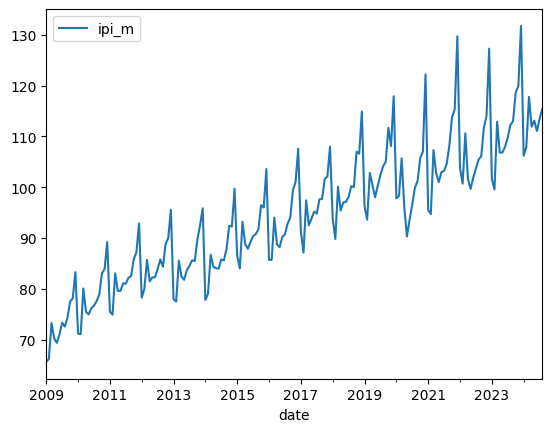

In [19]:
data.plot()
plt.show()

Видим в явном виде сезонность и тренд. Отлично подойдет для нашей модели